In [1]:
from pathlib import Path
from pdf2image import convert_from_path
import pytesseract
import re
from tqdm import tqdm
import pandas as pd

In [2]:
data_dir = Path('../data/ttct_figural/')
all_scans = list(data_dir.glob('**/*pdf'))
len(all_scans), all_scans[0]

(927, PosixPath('../data/ttct_figural/TTCT Post ASS SS 2011 E0L1/70830.pdf'))

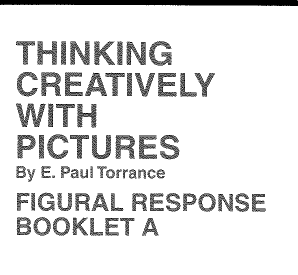

In [8]:
def parse_title_page(path, page=3):
    title_page = convert_from_path(path, 100, first_page=page, last_page=page, grayscale=True)[0]
    # crop NE corner and resize
    w,h = title_page.size
    title_crop = title_page.crop((int(w*0.65), 0, w, h//4))
    info_crop = title_page.crop((int(w*0.65), int(h*0.65), w, int(h*0.85)))
    return title_crop, info_crop

title_crop, info_crop = parse_title_page(all_scans[0])
title_crop

In [4]:
def get_booklet_info(rawtxt):
    booklet_info = re.findall('BOOKLET +.', rawtxt.upper().replace('\n', ' '))
    if len(booklet_info) == 0:
        booklet_info = rawtxt.upper().strip().split('\n')[-1]
    else:
        booklet_info = booklet_info[0]
    return booklet_info

def check_correct_page(txt):
    if len(txt) < 8:
        return False
    for snippet in ['THINKING', 'CREATIVE', 'PAUL', 'TORRENCE']:
        if snippet in txt.upper():
            return True
    else:
        return False

rawtxt = pytesseract.image_to_string(title_crop)
print(check_correct_page(rawtxt))
info = get_booklet_info(rawtxt)
info

True


'BOOKLET A'

In [76]:
data = []
for path in tqdm(all_scans):
    try:
        page = 3
        while True:
            title_crop, info_crop = parse_title_page(path, page=page)

            # info box is handwritten, so just save image and don't bother OCRing
            info_path = path.parent / (path.stem + '-info.jpg')
            info_crop.save(info_path)

            rawtxt = pytesseract.image_to_string(title_crop)
            if check_correct_page(rawtxt):
                info = get_booklet_info(rawtxt)
                break
            else:
                # wrong page, iterating down to find the right one 
                page -= 1
                if page <= 0:
                    print("Couldn't find the right page for ", path)
                info = None
    except KeyboardInterrupt:
        raise
    except:
        rawtxt, info = None, None
    data.append(dict(path=path, id=path.stem, booklet=info, fullocr=rawtxt, titlepage=page))

100%|██████████| 927/927 [08:25<00:00,  1.83it/s]


In [77]:
all_meta = pd.DataFrame(data)
all_meta.booklet = all_meta.booklet.str.replace(' ', '').fillna('').apply(lambda x: "".join([c for c in list(x) if c.isalnum()]))
for c in ['BOOKLETE', 'BOOKLETP', 'BOOKLET5']:
    all_meta.booklet = all_meta.booklet.str.replace(c, 'BOOKLETB')
for c in ['TT']:
    all_meta.booklet = all_meta.booklet.str.replace(c, 'BOOKLETA')
# drop some cols for privacy
all_meta[['id', 'booklet']].to_csv('../data/booklet-meta.csv')

## Manual Fixes

In [78]:
# most of the forms were parses, the rest should be done manually
(all_meta.booklet.value_counts() / all_meta.shape[0]).mul(100).round(1).head(10)

BOOKLETB      46.9
BOOKLETA      44.1
BOOKLE         2.8
BOOKLET        1.8
               0.4
BQOKLE         0.1
AH             0.1
PYCLOTRH       0.1
A554           0.1
FOUBSAFRET     0.1
Name: booklet, dtype: float64

../data/ttct_figural/Thurs PM McCammon Fall 2011 Post TTCT/75037.pdf


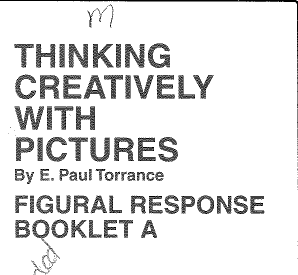

In [81]:
check_paths = all_meta[all_meta.booklet == 'BQOKLE'].path.tolist()
for path in check_paths:
    print(path)
    title_crop, info_crop = parse_title_page(path)
    display_png(title_crop)